In [ ]:
# default_exp data.covariates

In [70]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install 'tokenizers==0.9.3'
#! pip install 'transformers==3.5.0'

# Covariate Analysis and Feature Engineering 
>
>@danaderp 11.17.20 .
>

In [1]:
#export
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats as st
import os
import time

In [2]:
#export
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
#export
import functools 
from operator import or_
from collections import Counter
import datetime

In [4]:
#export
#import sentencepiece as spm
import pickle
from pathlib import Path
from tokenizers import Tokenizer, models

In [5]:
#export
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [6]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Fixing parameters

In [7]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'tb_01':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl',
        'tb_02':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy.jsonl',
        'output': dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/'
    }

In [8]:
""" TO BE USED JUST IN CASE
from icodegen.data.core import replace_spec_toks_to_original, java_special_tokens
df["original_code"] = replace_spec_toks_to_original(df, java_special_tokens).code.values
"""

' TO BE USED JUST IN CASE\nfrom icodegen.data.core import replace_spec_toks_to_original, java_special_tokens\ndf["original_code"] = replace_spec_toks_to_original(df, java_special_tokens).code.values\n'

In [9]:
params = params()

In [10]:
params['output'] / 'xxx.jsonl'

PosixPath('../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/xxx.jsonl')

In [11]:
#tst
logging.info( params['tokenizer'] )

2021-07-06 18:28:10,832 : INFO : ../dvc-icodegen/models/bpe/tokenizer-java-v1.json


In [12]:
df_error_tax = pd.read_json(
            params['tb_01'], orient="records", lines=True)

2021-07-06 18:28:13,799 : INFO : Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2021-07-06 18:28:13,800 : INFO : Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-07-06 18:28:13,800 : INFO : NumExpr defaulting to 8 threads.


In [13]:
df_error_tax.head()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,original_code,transformed_code,x_treatment
0,0.016686,NaN,8.931800e-06,NaN,3.518000e-07,NaN,NaN,0.000316,NaN,0.189851,private void success(io.netty.channel.Channel ...,<private> <void> success<(>io.netty.channel.Ch...,False
1,0.016562,NaN,8.914700e-06,NaN,3.518000e-07,NaN,NaN,0.000315,NaN,0.190934,private void success(io.netty.channel.Channel ...,<private> <void> success<(>io.netty.channel.Ch...,True
2,0.019514,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.131582,private void handleConnectRequest(com.assistan...,<private> <void> handleConnectRequest<(>com.as...,False
3,0.020454,NaN,1.240000e-08,NaN,3.518000e-07,0.00001,NaN,0.004353,NaN,0.129045,private void handleConnectRequest(com.assistan...,<private> <void> handleConnectRequest<(>com.as...,True
4,0.014277,NaN,1.757276e-04,NaN,3.090000e-07,NaN,NaN,0.000488,0.000028,0.162347,@java.lang.Override\nprotected void onSizeChan...,<@>java.lang.Override<n><protected> <void> onS...,False


In [192]:
df_error_tax.shape

(129444, 13)

In [14]:
df_cross = pd.read_json(
        params['tb_02'], orient="records", lines=True)

In [15]:
df_cross.head()

,transformed_code,y_cross_entropy,x_treatment,original_code
0,<private> <void> success<(>io.netty.channel.Ch...,6.006220,False,private void success(io.netty.channel.Channel ...
1,<private> <void> success<(>io.netty.channel.Ch...,6.008038,True,private void success(io.netty.channel.Channel ...
2,<private> <void> handleConnectRequest<(>com.as...,6.368741,False,private void handleConnectRequest(com.assistan...
3,<private> <void> handleConnectRequest<(>com.as...,6.337473,True,private void handleConnectRequest(com.assistan...
4,<@>java.lang.Override<n><protected> <void> onS...,3.927699,False,@java.lang.Override\nprotected void onSizeChan...


In [193]:
df_cross.shape

(129444, 4)

# First Covariate Analysis: Token Size

In [86]:
#Upload tokenizers here
#Use Tokenizer recent version
#Load tokenizer
#Update files (for one time) the main json files to add the column of tokenizers
#Count the tokens per method
#Visualize the most popular tokens (and less popular)

In [16]:
#export
class TokenizeHF():
    def __init__( self, no_padding = True, no_truncation = True ):
        """
        :param method: Code snippet (plain text)
        :returns: Encoded result using the provided tokenizer
        """
        #Load tokenizer
        self.tokenizer = Tokenizer.from_file( str( params['tokenizer'] ) )
        if no_padding:
            self.tokenizer.no_padding()
        if no_truncation:
            self.tokenizer.no_truncation()
        pass
    
    #@staticmethod
    def tokenizeHF(self, method ):
        output = {}
        # encode method and then convert to format that hf models expect
        encoding = self.tokenizer.encode( #Tokenize a Seq
            "<sos>" + method
        )
        """
        This source code is for further analysis
        output["input_ids"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.ids, dtype=tf.int32), 0
        )
        output["attention_mask"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.attention_mask, dtype=tf.int32), 0
        )"""
        return encoding
    
    #@staticmethod
    def decodingHF( self, idss ):
        return self.tokenizer.decode( idss , skip_special_tokens=False )
        #return self.tokenizer.convert_ids_to_tokens(idss )

In [17]:
code = df_cross['original_code']

In [18]:
code[0]

'private void success(io.netty.channel.Channel channel) {\n    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug("success info return form MySQLHandshakeHandler");\n    io.netty.buffer.ByteBuf out = channel.alloc().buffer();\n    org.mycat.netty.mysql.OK ok = new org.mycat.netty.mysql.OK();\n    ok.sequenceId = 2;\n    ok.setStatusFlag(Flags.SERVER_STATUS_AUTOCOMMIT);\n    out.writeBytes(ok.toPacket());\n    channel.writeAndFlush(out);\n}'

In [19]:
class_tokenize = TokenizeHF() 

In [20]:
input_ids = class_tokenize.tokenizeHF( method = 'this is a text <private> <void> success<(>io.netty' )

In [21]:
input_ids.ids

[1, 360, 492, 388, 1634, 189, 35, 189, 50, 3905, 83, 1702, 105, 3342, 487]

In [ ]:
input_ids.tokens

['<sos>',
 'this',
 'Ġis',
 'Ġa',
 'Ġtext',
 'Ġ',
 '<private>',
 'Ġ',
 '<void>',
 'Ġsuccess',
 '<(>',
 'io',
 '.',
 'net',
 'ty']

In [ ]:
input_ids = class_tokenize.tokenizeHF( method = code[0] )
#input_ids = input_ids['input_ids']
logging.info(input_ids)
#logging.info(input_ids.num_tokens)
logging.info(input_ids.ids)
logging.info(len(input_ids.ids))
logging.info(input_ids.tokens)

2021-07-02 17:57:43,923 : INFO : Encoding(num_tokens=177, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
2021-07-02 17:57:43,924 : INFO : [1, 35, 189, 50, 3905, 83, 1702, 105, 3342, 487, 105, 2867, 105, 1821, 2647, 84, 189, 79, 91, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 136, 180, 2298, 3943, 5731, 1072, 105, 1926, 105, 1025, 83, 93, 6150, 2399, 189, 38, 189, 23, 168, 464, 180, 2298, 3943, 5731, 1072, 93, 84, 85, 91, 195, 3644, 105, 3342, 487, 105, 2057, 105, 881, 3453, 1062, 189, 53, 2647, 105, 212, 2586, 83, 84, 105, 2057, 83, 84, 85, 91, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 4959, 189, 53, 189, 33, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 83, 84, 85, 91, 195, 4959, 105, 6909, 406, 189, 53, 883, 85, 91, 195, 4959, 105, 7941, 4880, 83, 4661, 105, 5872, 154, 5014, 154, 4723, 138, 9003, 84, 85, 91, 195, 1062, 105, 967, 1305, 83, 1649, 105, 

In [ ]:
class_tokenize.decodingHF( input_ids.ids )

'<sos><private> <void> handleConnectRequest<(>com.assistant.connection.ConnectionManager.ConnectRequest request<)> <{><n>    com.assistant.utils.Log.d<(>com.assistant.connection.ConnectionManager.TAG, <(>"handleConnectRequest, request<:>" <+> request<)><)><;><n>    <if> <(>mStopped<)> <{><n>        com.assistant.utils.Log.d<(>com.assistant.connection.ConnectionManager.TAG, "handleConnectRequest, mStopped is <true>"<)><;><n>        removeConnectRequest<(>request.connId<)><;><n>        not<if>yConnectionCreationResult<(><null>, request.listener, <true>, Connection.CONNECTION_REASON_CODE_CONNECT_REQUEST_CANCELED<)><;><n>        <return> <;><n>    <}><n>    connectToInternal<(>request.ipAddress, request.port, request.listener, request<)><;><n><}>'

### Generating the covariate column in the dataset
- For bootstrapping please follow [link](https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d)
- For confidence intervals follow [link](https://www.statology.org/confidence-intervals-python/)

In [19]:
#export
def method_size( method, class_tkz ):
    '''Return the size of the tokens for a give method based on id'''
    input_ids = class_tkz.tokenizeHF( method = method )
    return len(input_ids.ids)

In [ ]:
z_count_subwords = [method_size( class_tkz = class_tokenize, method = mtd )  for mtd in df_cross['code'].values] #using df_cross

In [ ]:
#Attaching new column
df_error_tax['z_count_subwords'] = z_count_subwords
df_cross['z_count_subwords'] = z_count_subwords

In [ ]:
df_error_tax.to_json(params['output'] / 'bug_fix_error_taxonomy_z_v1.jsonl', orient="records", lines=True)
df_cross.to_json(params['output'] / 'bug_fix_cross_entropy_z_v1.jsonl', orient="records", lines=True)

In [20]:
#export
def bootstrapping( np_data, np_func, size):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range(size) ]
    
    logging.info("Empirical Mean: " + str(np.mean(np_data))) #Empirical Mean
    logging.info( "Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return pd.DataFrame(bootstrap_repl, columns = ['bootstrap_repl'])

In [ ]:
np_data = [2,3,4,5,6,7,8,0]
np_boots = bootstrapping( np_data, np.mean, 100)

2021-06-30 17:50:24,875 : INFO : Empirical Mean: 4.375
2021-06-30 17:50:24,875 : INFO : Bootstrapped Mean: 4.39875


In [ ]:
st.sem(np_data)

0.9437293044088436

In [21]:
#export
def confidence_intervals(np_data, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = st.norm.interval(alpha=conf, loc = np.mean( np_data ), scale = st.sem(np_data))
    logging.info( CI )
    return CI

In [ ]:
confidence_intervals(np_boots.bootstrap_repl.values)
confidence_intervals(np_boots,conf=0.99)

2021-06-30 17:50:27,122 : INFO : (4.236137858789555, 4.561362141210444)
2021-06-30 17:50:27,124 : INFO : (array([4.18504142]), array([4.61245858]))


(array([4.18504142]), array([4.61245858]))

## Descriptive Statistics for first covariate (z_count_subwords)

In [22]:
# Configuration for Second Covariate Analysis
def params1():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'tb_01':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v0.jsonl',
        'tb_02':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v0.jsonl',
        'output': dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/',
        'ck_jar_path': dvc_path / 'nbs/tools/ck-metrics.jar',
        'physical_files_path': dvc_path/'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics'
    }

In [23]:
params1 = params1()

In [24]:
df_cross_v0 = pd.read_json(params1['tb_02'], orient="records", lines=True)
df_error_tax_v0 = pd.read_json(params1['tb_01'], orient="records", lines=True)

In [25]:
df_error_tax_v0.head(1)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,original_code,transformed_code,x_treatment,z_count_subwords
0,0.016686,NaN,0.000009,NaN,3.518000e-07,NaN,NaN,0.000316,NaN,0.189851,private void success(io.netty.channel.Channel ...,<private> <void> success<(>io.netty.channel.Ch...,False,177


In [26]:
df_cross_v0.round(3).head(1)

,transformed_code,y_cross_entropy,x_treatment,original_code,z_count_subwords
0,<private> <void> success<(>io.netty.channel.Ch...,6.006,False,private void success(io.netty.channel.Channel ...,177


In [27]:
df_error_tax_v0.describe()

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,z_count_subwords
count,129444.000000,3.237900e+04,1.280570e+05,7.080000e+02,8.949200e+04,7.478600e+04,3.163100e+04,1.238690e+05,5.470000e+04,129435.000000,129444.000000
mean,0.027398,6.619357e-06,1.560847e-03,2.682235e-06,7.849119e-07,1.756289e-05,2.001032e-05,2.942739e-03,1.386176e-05,0.138973,185.407628
std,0.018042,1.147974e-05,3.662612e-03,1.730872e-06,9.729956e-06,1.632367e-05,7.926272e-05,1.205765e-02,3.451656e-05,0.041075,64.357274
min,0.000492,1.300000e-09,8.000000e-10,1.842000e-07,4.300000e-09,2.500000e-09,7.630000e-08,1.400000e-09,2.400000e-09,0.000181,68.000000
25%,0.013624,8.082000e-07,8.300000e-08,1.641200e-06,1.819000e-07,7.591900e-06,4.239600e-06,1.492274e-04,8.347000e-07,0.111008,143.000000
50%,0.024140,1.648700e-06,8.668500e-06,2.242750e-06,3.461000e-07,1.201850e-05,9.298200e-06,3.664036e-04,3.514200e-06,0.137228,176.000000
75%,0.037357,8.043200e-06,1.417618e-03,3.153475e-06,4.551000e-07,2.195810e-05,1.711530e-05,1.072184e-03,1.234690e-05,0.164987,216.000000
max,0.180986,2.466836e-04,1.678386e-01,1.249600e-05,1.013232e-03,5.137535e-04,8.033565e-03,4.924544e-01,1.900545e-03,0.369389,4465.000000


In [31]:
df_cross_v0.describe().round(3)

,y_cross_entropy,z_count_subwords
count,129444.000,129444.000
mean,6.143,185.408
std,1.511,64.357
min,2.066,68.000
25%,5.039,143.000
50%,5.983,176.000
75%,7.085,216.000
max,12.283,4465.000


<AxesSubplot:title={'center':'z_count_subwords'}, xlabel='[x_treatment]'>

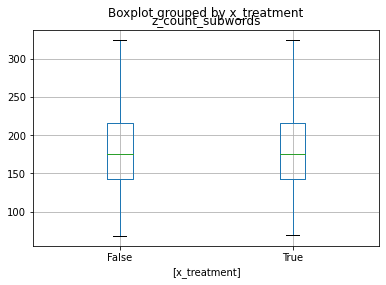

In [32]:
#first covariate by treatment
df_cross_v0[['z_count_subwords','x_treatment']].boxplot( 
    by='x_treatment',
    showfliers=False,
)

### Correlation Analysis Entropy

In [33]:
LIM = 500
S = 2

In [34]:
df_buggy_cross_v0 = df_cross_v0.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy_cross_v0 = df_cross_v0.loc[lambda row: row['x_treatment'] == False  ].copy()

In [35]:
df_nonbuggy_cross_v0.describe()

,y_cross_entropy,z_count_subwords
count,64722.000000,64722.000000
mean,6.148851,185.643460
std,1.513355,64.668787
min,2.118368,68.000000
25%,5.047101,143.000000
50%,5.987264,176.000000
75%,7.099688,216.000000
max,12.283474,4448.000000


<AxesSubplot:xlabel='z_count_subwords', ylabel='y_cross_entropy'>

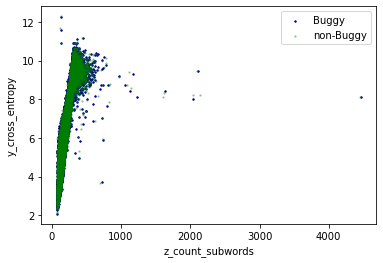

In [36]:
ax = df_buggy_cross_v0.plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="DarkBlue", label="Buggy")
df_nonbuggy_cross_v0.plot.scatter(x="z_count_subwords", y="y_cross_entropy", s= S,color="Green", label="non-Buggy", alpha=0.3, ax=ax)

In [37]:
def corrcoef(v,w):
    x = np.corrcoef(v,w)
    x = np.round(x[0][1],3)
    return x

In [38]:
#General Correlation
corrcoef(df_cross_v0.y_cross_entropy.values,df_cross_v0.z_count_subwords.values)

0.87

In [39]:
#Buggy Correlation
corrcoef(df_buggy_cross_v0.y_cross_entropy.values, df_buggy_cross_v0.z_count_subwords.values)

0.873

In [40]:
#NonBuggy Correlation
corrcoef(df_nonbuggy_cross_v0.y_cross_entropy.values, df_nonbuggy_cross_v0.z_count_subwords.values)

0.867

<AxesSubplot:xlabel='z_count_subwords', ylabel='y_cross_entropy'>

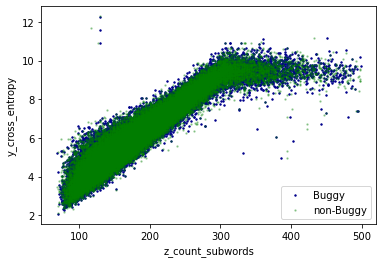

In [41]:
ax = df_buggy_cross_v0.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="DarkBlue", label="Buggy")
df_nonbuggy_cross_v0.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="Green", label="non-Buggy", alpha=0.3, ax=ax)

### Correlation Analysis Error Taxonomy

In [42]:
taxonomy = ['y_blocks',
'y_exceptions','y_oop','y_tests',
'y_declarations','y_conditionals','y_loops',
'y_operators','y_datatypes','y_extra_tokens']

In [43]:
df_buggy_error_tax_v0  = df_error_tax_v0.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy_error_tax_v0  = df_error_tax_v0.loc[lambda row: row['x_treatment'] == False  ].copy()

In [172]:
df_error_tax_v0['y_exceptions'][df_error_tax_v0['y_exceptions'].isnull()] #Counting nans

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
129435   NaN
129438   NaN
129439   NaN
129440   NaN
129441   NaN
Name: y_exceptions, Length: 97065, dtype: float64

In [44]:
df_error_tax_v0[['y_exceptions','z_count_subwords']].dropna(axis=0, how='any')

,y_exceptions,z_count_subwords
10,2.952000e-07,142
11,2.952000e-07,137
14,9.763000e-07,147
15,7.271000e-07,142
26,9.242300e-06,125
...,...,...
129429,5.148000e-07,167
129436,8.380000e-07,137
129437,8.394000e-07,120
129442,9.771000e-07,140


In [44]:
df_temp = df_error_tax_v0[['y_blocks','z_count_subwords']].dropna(axis=0, how='any')
logging.info( 'y_blocks' + str( corrcoef(df_temp['y_blocks'].values, df_temp.z_count_subwords.values) ) )

2021-07-06 18:33:11,095 : INFO : y_blocks-0.102


In [45]:
#General Correlation
for i in taxonomy:
    df_temp = df_error_tax_v0[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-06 18:33:21,773 : INFO : y_blocks:-0.102
2021-07-06 18:33:21,778 : INFO : y_exceptions:0.013
2021-07-06 18:33:21,785 : INFO : y_oop:0.029
2021-07-06 18:33:21,789 : INFO : y_tests:-0.046
2021-07-06 18:33:21,796 : INFO : y_declarations:-0.003
2021-07-06 18:33:21,804 : INFO : y_conditionals:0.03
2021-07-06 18:33:21,809 : INFO : y_loops:0.1
2021-07-06 18:33:21,816 : INFO : y_operators:0.015
2021-07-06 18:33:21,821 : INFO : y_datatypes:-0.043
2021-07-06 18:33:21,828 : INFO : y_extra_tokens:0.025


In [46]:
#Buggy Correlation
for i in taxonomy:
    df_temp = df_buggy_error_tax_v0[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-06 18:33:22,866 : INFO : y_blocks:-0.103
2021-07-06 18:33:22,870 : INFO : y_exceptions:0.013
2021-07-06 18:33:22,875 : INFO : y_oop:0.028
2021-07-06 18:33:22,878 : INFO : y_tests:-0.047
2021-07-06 18:33:22,883 : INFO : y_declarations:-0.004
2021-07-06 18:33:22,890 : INFO : y_conditionals:0.026
2021-07-06 18:33:22,894 : INFO : y_loops:0.098
2021-07-06 18:33:22,898 : INFO : y_operators:0.018
2021-07-06 18:33:22,904 : INFO : y_datatypes:-0.044
2021-07-06 18:33:22,910 : INFO : y_extra_tokens:0.023


In [47]:
#nonBuggy Correlation
for i in taxonomy:
    df_temp = df_nonbuggy_error_tax_v0[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-06 18:33:25,359 : INFO : y_blocks:-0.102
2021-07-06 18:33:25,363 : INFO : y_exceptions:0.014
2021-07-06 18:33:25,367 : INFO : y_oop:0.029
2021-07-06 18:33:25,370 : INFO : y_tests:-0.047
2021-07-06 18:33:25,374 : INFO : y_declarations:-0.003
2021-07-06 18:33:25,379 : INFO : y_conditionals:0.033
2021-07-06 18:33:25,383 : INFO : y_loops:0.101
2021-07-06 18:33:25,389 : INFO : y_operators:0.013
2021-07-06 18:33:25,394 : INFO : y_datatypes:-0.043
2021-07-06 18:33:25,399 : INFO : y_extra_tokens:0.027


In [ ]:
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ]

0         177
1         177
2         195
3         195
4         121
         ... 
129439    196
129440    199
129441    195
129442    140
129443    142
Name: z_count_subwords, Length: 96787, dtype: int64

### Bootstrapping of Means [z_count_subwords]

In [48]:
bs_cross = bootstrapping( df_cross_v0.z_count_subwords.values , np.mean, 500)

2021-07-06 18:33:40,134 : INFO : Empirical Mean: 185.4076280090232
2021-07-06 18:33:40,135 : INFO : Bootstrapped Mean: 185.3918577763357


In [49]:
confidence_intervals( bs_cross.bootstrap_repl.values )

2021-07-06 18:33:41,942 : INFO : (185.37534785223545, 185.40836770043597)


(185.37534785223545, 185.40836770043597)

<AxesSubplot:ylabel='Frequency'>

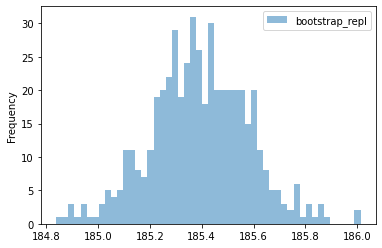

In [50]:
bs_cross.plot.hist(alpha=0.5, bins=50)

### Empirical PDF and CDF [z_count_subwords]

<AxesSubplot:ylabel='Frequency'>

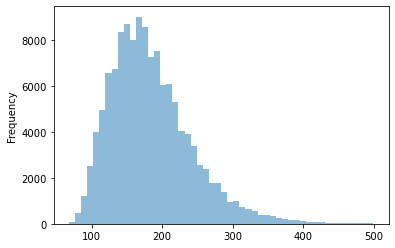

In [51]:
# Empirical PDF or Probability Density Function
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist(alpha=0.5, bins=50)

<AxesSubplot:ylabel='Density'>

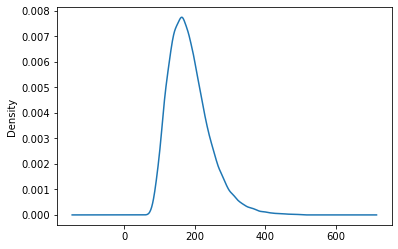

In [52]:
# PDF or Probability Density Function
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.kde()

<AxesSubplot:ylabel='Frequency'>

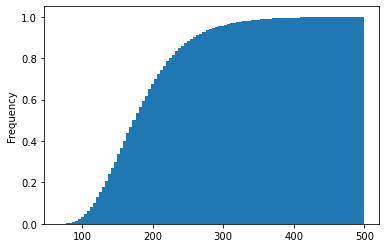

In [53]:
#Empirical CDF demonstrate that 50% of methods in our sample have around 180 or less tokens. 
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist( 
    cumulative = True,
    density =1,
    bins=100
)

# Second Covariate Analysis: SE Metrics
> This module provides a tool for computing metrics (from static analysis) for python source code using Using <a href="https://github.com/mauricioaniche/ck">CK Package</a>

CK is a java package (jar) which is going to be executed from terminal. It requires the code which is going to be analyzed to be located at <i>physical</i> files. For that reason, the dataset is going to be used to produce some <i>.java</i> files.

Each record, corresponds to a individual class. When working with method-level snippets, "articial" classes are created for performing the analysis.

In [54]:
from subprocess import *
import os
import shutil

In [55]:
Popen

subprocess.Popen

In [56]:
# export
def write_dataset_to_files(df_series, destination_path):
    """
    Function to generate .java files.
    
    Params:
    # df_series: Pandas Series (DataFrame column) with the source code records.
    # destination_path: (str) Absolute path to be used as directory for the generated files.
    
    Returns:
    
    Collection of paths for the corresponding java files.
    
    """
    java_template = 'public class <class_name>{\n    <code_snippet>\n}'
    
    if not os.path.exists(destination_path):
        logging.info('Creating directory.')
        os.mkdir(destination_path)
    
    logging.info("Generating physical .java files.")
    
    file_paths = []
    for idx, value in df_series.iteritems():
        class_name = f'ClassRecord{idx}'
        code = java_template.replace('<class_name>', class_name)
        code = code.replace('<code_snippet>', value)
        file_path = f'{destination_path}/{class_name}.java'
        with open(file_path, 'w') as file:
            file.write(code)
            file_paths.append(file_path)
            
    return file_paths

In [57]:
# export
def jarWrapper(*args):
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [58]:
# export
class JavaAnalyzer():
    """
    Class get metrics f
    """
    def __init__(self, ck_jar_path):
        self.ck_jar_path = ck_jar_path
    
    def compute_metrics(self, df_series, files_destination_path):
        """
        Computes metrics for a pandas series of java source code snippets
        
        Params
        # df_series: Pandas series (df column) containing java source snippets
        # files_destination_path: Path indicating where the physical .java files are going to be created (for metrics computation)
        
        Returns:
        
        Pandas Dataframe containing metrics
        
        """
        file_paths = write_dataset_to_files(df_series, files_destination_path)
        self.__call_ck_package(files_destination_path)
        metrics_df = self.__get_metrics_df()
        self.__remove_csv_files()
        self.__remove_tmp_java_files(file_paths)
        
        return metrics_df
        
    def __call_ck_package(self, files_path):
        """
        Performs call to external .jar package.
        """
        args = [self.ck_jar_path, files_path, 'false', '0', 'True']
        result = jarWrapper(*args)
        logging.info(f'CK package produced this output:\n{result}')
        
    def __get_metrics_df(self):
        """
        Reads report files (csv) generated by the CK package.
        
        Returns:
        
        Pandas Dataframe containing appropriate metrics
        """
        class_metrics_df = pd.read_csv('class.csv')
        # method_metrics_df = pd.read_csv('method.csv')

        # merged_df = pd.merge(left = class_metrics_df, right = method_metrics_df, left_on='file', right_on='file')

        appropriate_columns = ['file','class', 'wmc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty',
                          'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty','synchronizedMethodsQty',
                          'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
                          'defaultFieldsQty', 'visibleFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty',
                          'nosi', 'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
                          'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty',
                          'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'uniqueWordsQty', 'modifiers']

        class_metrics_df = class_metrics_df[appropriate_columns]

        return class_metrics_df
    
    def __remove_csv_files(self):
        """
        Removes files generated by CK package.
        """
        if os.path.exists('class.csv'):
            os.remove('class.csv')
        if os.path.exists('method.csv'):
            os.remove('method.csv')
        if os.path.exists('field.csv'):
            os.remove('field.csv')
            
    def __remove_tmp_java_files(self, paths):
        """
        Removes the temporary generated java files.
        """
        for file_path in paths:
            os.remove(file_path)

In [59]:
# Configuration for Second Covariate Analysis
def params2():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'tb_01':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v0.jsonl',
        'tb_02':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v0.jsonl',
        'output': dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/',
        'ck_jar_path': dvc_path / 'nbs/tools/ck-metrics.jar',
        'physical_files_path': dvc_path/'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics'
    }

In [60]:
params2 = params2()

In [61]:
str(params2['ck_jar_path'])

'../dvc-icodegen/nbs/tools/ck-metrics.jar'

In [63]:
params2['ck_jar_path']

PosixPath('../dvc-icodegen/nbs/tools/ck-metrics.jar')

In [126]:
df_cross_v0.head(1)

,transformed_code,y_cross_entropy,x_treatment,original_code,z_count_subwords,file
0,<private> <void> success<(>io.netty.channel.Ch...,6.00622,False,private void success(io.netty.channel.Channel ...,177,../dvc-icodegen/nbs/nbs_experiments/results/an...


In [65]:
df_error_tax_v0.head(1)

,y_blocks,y_exceptions,y_oop,y_tests,y_declarations,y_conditionals,y_loops,y_operators,y_datatypes,y_extra_tokens,original_code,transformed_code,x_treatment,z_count_subwords
0,0.016686,NaN,0.000009,NaN,3.518000e-07,NaN,NaN,0.000316,NaN,0.189851,private void success(io.netty.channel.Channel ...,<private> <void> success<(>io.netty.channel.Ch...,False,177


In [66]:
java_analyzer = JavaAnalyzer( params2['ck_jar_path'] )

In [79]:
#Updates df_cross_v0
#Becareful to not recompute this code, make sure to erase the folder afterwards
df_cross_v0_paths = write_dataset_to_files( df_cross_v0['original_code'], params2['physical_files_path'] )

2021-07-06 20:50:25,036 : INFO : Generating physical .java files.


In [114]:
df_cross_v0['original_code'][0]

'private void success(io.netty.channel.Channel channel) {\n    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug("success info return form MySQLHandshakeHandler");\n    io.netty.buffer.ByteBuf out = channel.alloc().buffer();\n    org.mycat.netty.mysql.OK ok = new org.mycat.netty.mysql.OK();\n    ok.sequenceId = 2;\n    ok.setStatusFlag(Flags.SERVER_STATUS_AUTOCOMMIT);\n    out.writeBytes(ok.toPacket());\n    channel.writeAndFlush(out);\n}'

In [81]:
df_cross_v0_paths[0]

'../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord0.java'

In [127]:
file_path = ['/home/jovyan/work/nbs/'+i for i in df_cross_v0_paths]

In [220]:
len(file_path)

129444

In [129]:
#updating main frames with filepaths
df_cross_v0['file'] = file_path

In [130]:
df_cross_v0.head(1)

,transformed_code,y_cross_entropy,x_treatment,original_code,z_count_subwords,file
0,<private> <void> success<(>io.netty.channel.Ch...,6.00622,False,private void success(io.netty.channel.Channel ...,177,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...


In [ ]:
#renaming just in case
df_cross_v0.rename(columns = {'file':'file'}, inplace = True)

In [131]:
assert len(df_cross_v0_paths) == len(df_error_tax_v0)

In [95]:
df_cross_v0_java_metrics = java_analyzer.compute_metrics( df_cross_v0['original_code'], params2['physical_files_path'] )

2021-07-06 21:58:35,544 : INFO : Generating physical .java files.
2021-07-06 23:29:06,703 : INFO : CK package produced this output:
[b'', b'log4j:WARN No appenders could be found for logger (com.github.mauricioaniche.ck.CK).', b'log4j:WARN Please initialize the log4j system properly.', b'']


In [235]:
df_cross_v0_java_metrics.shape

(132540, 39)

### Anonymous Class Treatment

In [229]:
#tst
cnt = Counter()
redundant_class = [] #Anonimous Classes Paths

In [230]:
#tst
for path in file_path:
    instances = df_cross_v0_java_metrics[df_cross_v0_java_metrics['file']==path].shape[0]
    cnt[path] += instances
    if instances > 1:
        redundant_class.append([instances,path])

In [231]:
len(redundant_class)

2904

In [233]:
redundant_class[0]

[2,
 '/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord170.java']

In [234]:
len(cnt[''])

129444

In [239]:
#Non anonimous clases
temporal = [i for i in cnt.values() if i==1]

In [240]:
len(temporal)

126540

In [224]:
#tst
df_cross_v0_java_metrics.head(1)

,file,class,wmc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
0,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord52629,2,1,0,0,1,0,0,0,...,0,4,0,2,1,0,0,0,13,1


In [218]:
df_cross_v0_java_metrics.shape

(132540, 39)

In [241]:
#With Anonymous
df_cross_v0_java_metrics_anony = df_cross_v0_java_metrics[df_cross_v0_java_metrics['class'].str.contains('Anonymous')].copy() 

#df_cross_v0_java_metrics_anony = df_cross_v0_java_metrics[df_cross_v0_java_metrics['class'].str.contains('Anonymous') &  
#                                                     (df_cross_v0_java_metrics['anonymousClassesQty']!=0)].copy() 

In [242]:
df_cross_v0_java_metrics_anony.shape

(3049, 39)

In [213]:
df_cross_v0_java_metrics_anony.head(1)

,file,class,wmc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
163,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord121896$Anonymous1,1,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,2,-1


In [208]:
df_cross_v0_java_metrics_anony_tmp = df_cross_v0_java_metrics[df_cross_v0_java_metrics['anonymousClassesQty']!=0].copy()

In [209]:
df_cross_v0_java_metrics_anony_tmp.shape

(2917, 39)

In [210]:
df_cross_v0_java_metrics_anony_tmp

,file,class,wmc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
18,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord23299,4,1,0,0,0,0,1,1,...,1,1,0,0,1,1,0,0,16,1
109,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord69514,1,1,0,1,0,0,0,1,...,0,1,0,1,0,1,0,0,18,1
115,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord64397,1,1,0,1,0,0,0,1,...,1,1,0,1,0,1,0,0,6,1
148,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord112685,1,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,6,1
162,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord121896,2,1,0,1,0,0,0,1,...,0,2,0,2,1,1,0,0,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132123,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord25489,3,1,0,0,1,0,0,0,...,0,1,0,0,2,1,0,0,9,1
132135,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord40945,1,1,0,0,1,0,0,0,...,0,1,0,1,0,3,0,0,7,1
132163,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord86163,1,1,0,1,0,0,0,1,...,1,1,0,0,0,1,0,0,4,1
132321,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord24210,1,1,1,1,0,0,0,1,...,3,3,0,0,0,1,0,0,4,1


In [214]:
#Without Anonymous
df_cross_v0_java_metrics_base = df_cross_v0_java_metrics[~df_cross_v0_java_metrics['class'].str.contains('Anonymous') &
                                                        (df_cross_v0_java_metrics['anonymousClassesQty']==0)].copy()

In [219]:
df_cross_v0_java_metrics

,file,class,wmc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
0,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord52629,2,1,0,0,1,0,0,0,...,0,4,0,2,1,0,0,0,13,1
1,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord117102,2,1,0,1,0,0,0,1,...,8,0,2,0,1,0,0,0,6,1
2,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord91512,4,1,0,0,1,0,0,0,...,2,1,0,1,1,0,0,0,14,1
3,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord42082,2,1,0,1,0,0,0,1,...,0,1,0,1,1,0,0,0,13,1
4,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord98590,3,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132535,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord110729,3,1,0,1,0,0,0,1,...,0,3,0,3,2,0,0,0,9,1
132536,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord27302,3,1,0,1,0,0,0,1,...,2,1,0,0,2,0,0,0,11,1
132537,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord85623,1,1,0,1,0,0,0,1,...,11,8,0,1,0,0,0,0,20,1
132538,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord5976,3,1,0,0,0,0,1,1,...,2,1,0,1,2,0,0,0,7,1


In [215]:
df_cross_v0_java_metrics.shape

(126628, 39)

In [186]:
assert len(df_cross_v0) == len(df_cross_v0_java_metrics_base)

AssertionError: 

In [187]:
len(df_cross_v0)

129444

In [69]:
#saving
df_cross_v0_java_metrics.to_json(params2['output'] / 'ck-metrics.jsonl', orient="records", lines=True)

In [132]:
#Merging DataFrames
df_cross_v1 = pd.merge( df_cross_v0, df_cross_v0_java_metrics, on = 'file' )

In [133]:
len(df_cross_v1)

132540

In [194]:
df_cross_v1.head(1)

,transformed_code,y_cross_entropy,x_treatment,original_code,z_count_subwords,file,class,wmc,totalMethodsQty,staticMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
0,<private> <void> success<(>io.netty.channel.Ch...,6.00622,False,private void success(io.netty.channel.Channel ...,177,/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...,ClassRecord0,1,1,0,...,1,3,0,2,0,0,0,0,8,1


In [195]:
df_cross_v1_anony = df_cross_v1[df_cross_v1['class'].str.contains('Anonymous')].copy() 

In [196]:
df_cross_v1_anony.shape

(3049, 44)

In [197]:
df_cross_v1_base = df_cross_v1[~df_cross_v1['class'].str.contains('Anonymous')].copy()

In [198]:
df_cross_v1_base.shape

(129491, 44)

In [173]:
df_cross_v1[df_cross_v1['class']=='ClassRecord105270']['original_code'].values

array(['private void initLeftButton() {\n    android.widget.FrameLayout fl = ((android.widget.FrameLayout) (this.findViewById(R.id.flLeftButton)));\n    com.joshsera.ViewGroup.LayoutParams lp = fl.getLayoutParams();\n    fl.setLayoutParams(lp);\n    fl.setOnTouchListener(new android.view.View.OnTouchListener() {\n        public boolean onTouch(android.view.View v, android.view.MotionEvent ev) {\n            return onLeftTouch(ev);\n        }\n    });\n    this.flLeftButton = fl;\n}'],
      dtype=object)

In [151]:
df_cross_v1.loc[2]

transformed_code          <private> <void> handleConnectRequest<(>com.as...
y_cross_entropy                                                     6.36874
x_treatment                                                           False
original_code             private void handleConnectRequest(com.assistan...
z_count_subwords                                                        195
file                      /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...
class                                                          ClassRecord2
wmc                                                                       2
totalMethodsQty                                                           1
staticMethodsQty                                                          0
publicMethodsQty                                                          0
privateMethodsQty                                                         1
protectedMethodsQty                                                       0
defaultMetho

In [152]:
df_cross_v1.loc[2][3]

'private void handleConnectRequest(com.assistant.connection.ConnectionManager.ConnectRequest request) {\n    com.assistant.utils.Log.d(com.assistant.connection.ConnectionManager.TAG, ("handleConnectRequest, request:" + request));\n    if (mStopped) {\n        com.assistant.utils.Log.d(com.assistant.connection.ConnectionManager.TAG, "handleConnectRequest, mStopped is true");\n        removeConnectRequest(request.connId);\n        notifyConnectionCreationResult(null, request.listener, true, Connection.CONNECTION_REASON_CODE_CONNECT_REQUEST_CANCELED);\n        return ;\n    }\n    connectToInternal(request.ipAddress, request.port, request.listener, request);\n}'

# Descriptive Statistics

hierarchical:
- [hierarchical] wmc: Weight Method Class or McCabe's complexity

code size:
- [code size] loc: Lines of code
- [code size] Number of methods: Count the number of fields, both total (totalMethodsQty) and specific (i.e., static, public, abstract, private, protected, default, final, and synchronized)
- [code size] totalMethodsQty:
- [code size] staticMethodsQty
- [code size] publicMethodsQty
- [code size] privateMethodsQty
- [code size] protectedMethodsQty
- [code size] defaultMethodsQty
- [code size] abstractMethodsQty
- [code size] finalMethodsQty
- [code size] synchronizedMethodsQty
- [code size] Number of fields: Count the number of fields, both total (totalFieldsQty) and specific (i.e., static, public, private, protected, default, final, and synchronized)
- [code size] totalFieldsQty
- [code size] staticFieldsQty
- [code size] publicFieldsQty
- [code size] privateFieldsQty
- [code size] protectedFieldsQty
- [code size] defaultFieldsQty
- [code size] visibleFieldsQty
- [code size] finalFieldsQty
- [code size] synchronizedFieldsQty
- [code size] anonymousClassesQty: Number of anonymous classes
- [code size] innerClassesQty: Number of inner classes
- [code size] lambdasQty: Number of lambda expressions

structural:
- [structural] returnQty: Number of return instructions
- [structural] loopQty: Number of loops (i.e., for, while, do while, enhanced for).
- [structural] comparisonsQty: Number of comparisons (i.e., == and !=)
- [structural] tryCatchQty: Number of try/catch blocks
- [structural] parenthesizedExpsQty: The number of expressions inside parenthesis
- [structural] nosi: number of invocations to static methods. It can only count the ones that can be resolved by the JDT.
- [structural] assignmentsQty
- [structural] mathOperationsQty: The number of math operations (times, divide, remainder, plus, minus, left shit, right shift).
- [structural] variablesQty: Number of declared variables
- [structural] maxNestedBlocksQty: The highest number of blocks nested together.
- [structural] stringLiteralsQty: Number of string literals
- [structural] numbersQty: Number of numeric literals
- [structural] modifiers: public/abstract/private/protected/native modifiers of classes/methods

word size:
- [word size] uniqueWordsQty: Number of unique words: Number of unique words in the source code. At method level, it only uses the method body as input. At class level, it uses the entire body of the class as metrics. The algorithm basically counts the number of words in a method/class, after removing Java keywords.


All Java Set

In [70]:
df_cross_v0_java_metrics.describe()

,wmc,totalMethodsQty,staticMethodsQty,publicMethodsQty,privateMethodsQty,protectedMethodsQty,defaultMethodsQty,abstractMethodsQty,finalMethodsQty,synchronizedMethodsQty,...,numbersQty,assignmentsQty,mathOperationsQty,variablesQty,maxNestedBlocksQty,anonymousClassesQty,innerClassesQty,lambdasQty,uniqueWordsQty,modifiers
count,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.0,132540.000000,...,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000,132540.000000
mean,2.455470,1.001298,0.125449,0.711793,0.202784,0.064750,0.021971,0.799208,0.0,0.008322,...,0.895450,1.846567,0.559989,1.206519,0.999366,0.023004,0.000355,0.005953,11.183771,0.953637
std,1.310938,0.077583,0.331228,0.460283,0.402075,0.246759,0.146691,0.409627,0.0,0.090845,...,1.705478,1.584186,1.350558,1.161094,0.832667,0.156805,0.020368,0.091444,5.059827,0.300372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,...,1.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,13.000000,1.000000
max,18.000000,4.000000,1.000000,4.000000,1.000000,3.000000,2.000000,4.000000,0.0,1.000000,...,41.000000,19.000000,21.000000,11.000000,6.000000,4.000000,2.000000,5.000000,336.000000,1.000000
